# This notebook:
### Demonstration for identification of traces in NIRISS WFSS data originated from optical ghosts.

## Output products:
- Segmentation image for identified ghosts.

Users will be able to compare their input WFSS image with this segmap to distinguish wfss ghosts.

### Ghosts will be identified based on a priori knowledge of 
    1. GAP (currently derived with CV3 data),
    2. source positions in the direct image (ie. source catalog of the direct image)

### Ghost id script is located at:
https://github.com/spacetelescope/niriss_ghost

In [1]:
import os
import sys
import h5py
import string
import numpy as np
import scipy
from scipy.stats import binned_statistic_2d
import math
import glob

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(10,10)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.patches as patches

import astropy
from astropy.visualization import simple_norm
from astropy.io import fits,ascii
from astropy.table import Table
from astropy import units as u
import asdf

import jwst
from jwst import datamodels
from jwst import assign_wcs
from jwst.assign_wcs import assign_wcs_step

import grismconf

# For photutils;
import astropy.wcs as wcs
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog, source_properties
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
f_deblend = True                


# From https://github.com/spacetelescope/niriss_ghost
import niriss_ghost
import niriss_ghost.detect_ghost_image2
from niriss_ghost.utils import get_corners,get_gap_wfss,get_ghost_wfss


In [2]:
print('pipeline:',jwst.__version__)
print('astropy:',astropy.__version__)
print('numpy:',np.__version__)
print('scipy:',scipy.__version__)
print('asdf:',asdf.__version__)
print('niriss_ghost',niriss_ghost.__version__)


pipeline: 1.3.2.dev12+g2685f8f7
astropy: 4.3.1
numpy: 1.20.1
scipy: 1.6.1
asdf: 2.8.1
niriss_ghost 1.0.0


## 0. Preparation

In [3]:
# Target filter;
filts = ['F090W','F115W','F140M','F150W','F158M','F200W']
#iiw = 5
#filt = filts[iiw]

# Output directory for the products from this script;
DIR_OUT = './output/'


### Get ghost positions in direct image

In [4]:
DIR_DAT = '../../NIS-016_Sep21_full/reduced_newreffile/'

# Ex.1 with R grism.
# ID00054 corresponds to the direc image of the target file, 00053.
#id_direct = '00054'
#id_wfss = '00053'

# Ex.2 with C grism.
# ID00049 corresponds to the direc image of the target file, 00057.
id_direct = '00049'
id_wfss = '00057'

# The source catalog, cat_direct, was obtained by running photutils on direct image;
file_direct = '%s/jw01090001001_01101_%s_nis_cal.fits'%(DIR_DAT,id_direct)
cat_direct = '%s/jw01090001001_01101_%s_nis_cat_man.ecsv'%(DIR_DAT,id_direct)
ratenames = glob.glob('%s/jw01090001001_01101_%s_nis_rate.fits'%(DIR_DAT,id_wfss))


### Run ghost id script on the direct image;

In [5]:
# Run;
niriss_ghost.detect_ghost_image2.run([file_direct], [cat_direct], keyword_id='label', keyword_flux='segment_flux',
                                    DIR_OUT=DIR_OUT)
# Equivalently;
# $python ~/GitHub/niriss_ghost/niriss_ghost/detect_ghost_image2.py ../../NIS-016_Aug21_full/reduced/jw01090001001_01101_00049_nis_cal.fits ../../NIS-016_Aug21_full/reduced/jw01090001001_01101_00049_nis_cat_man.ecsv 


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Running ghost detection script
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Target coordinates are: 81.0818057202483 -70.08363513442043


2021-11-04 20:50:39,669 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_2.0/lib/python3.7/site-packages/astropy/units/format/vounit.py:115: UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
  core.UnitsWarning)



Catalog saved to : ./output/ghost_detected_cat_jw01090001001_01101_00049_nis_cal.txt
Using gap summary file: /Users/tmorishita/anaconda3/envs/mirage_2.0/lib/python3.7/site-packages/niriss_ghost-1.0.0-py3.7.egg/niriss_ghost//niriss_ghost_gap_summary.txt
Plot saved to : ./output//results_jw01090001001_01101_00049_nis_cal.png

Tweaking DQ array...
No segmtation map specified by --segmap. Guessing from the input image name...

New image with updated DQ saved to: ./output/jw01090001001_01101_00049_nis_cal_gst.fits

Successfully done! (1/1)



In [6]:
# Open ghost catalog;
file_cat = DIR_OUT+'ghost_detected_cat_jw01090001001_01101_%s_nis_cal.txt'%id_direct
fd_cat = ascii.read(file_cat)
print(file_cat)
print(fd_cat)

# Open source catalog of direct image;
# obtained either by image2 or manually running photutils.
# This is to get the source size, to predict the trace.
fd_src = ascii.read(cat_direct)
keyword_radius = 'semimajor_sigma' #'equivalent_radius'
equivalent_radius = fd_src[keyword_radius]


./output/ghost_detected_cat_jw01090001001_01101_00049_nis_cal.txt
 id     ra         dec          x       ...  id_src    ra_src     dec_src  
--- ---------- ----------- ------------ ... -------- ---------- -----------
  1 81.0634519  -70.090869  1361.989389 ...     25.0 81.0858615 -70.0792891
  2 81.0670622 -70.0885776 1296.1049384 ...     22.0  81.082279 -70.0815863
  3 81.0876028 -70.0886221        911.0 ...      nan        nan         nan
  4 81.0611338 -70.0878319 1407.8074066 ...      nan        nan         nan
  5 81.0638076 -70.0874298 1358.0029467 ... 100004.0 81.0855275 -70.0827451
  6 81.0833695 -70.0873001  991.3783098 ...      nan        nan         nan
  7 81.0867376 -70.0871142  928.3699955 ...      nan        nan         nan
  8 81.0904352 -70.0867764  859.2935849 ...      nan        nan         nan
  9 81.0603619 -70.0867602 1423.1139369 ...     17.0 81.0889711 -70.0833978
 10 81.0580896 -70.0865328 1465.8854602 ...     15.0 81.0913774 -70.0836382
...        ...        

### Run photutils on WFSS data, to get trace segments

Running photutils on ../../NIS-016_Sep21_full/reduced_newreffile//jw01090001001_01101_00057_nis_rate.fits


2021-11-04 20:52:40,016 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_2.0/lib/python3.7/site-packages/astropy/wcs/wcs.py:517: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)

2021-11-04 20:52:43,600 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_2.0/lib/python3.7/site-packages/ipykernel_launcher.py:45: AstropyDeprecationWarning: The source_properties function is deprecated and may be removed in a future version.
        Use `~photutils.segmentation.SourceCatalog` instead.

2021-11-04 20:52:43,607 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_2.0/lib/python3.7/site-packages/photutils/segmentation/properties.py:1897: AstropyDeprecationWarning: The SourceProperties class is deprecated and may be removed in a future version.
        Use `~photutils.segmentation.SourceCatalog` instead.
  localbkg_width=localbkg_width, kron_params=kron_params))

202

Segment file saved to jw01090001001_01101_00057_nis_rate_seg.fits


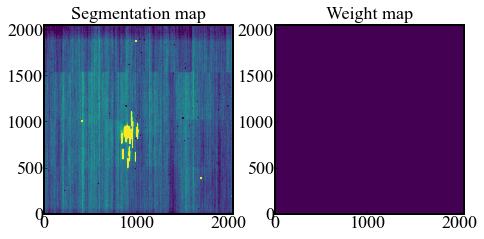

In [12]:

for infile in ratenames[:]:
    print('Running photutils on',infile)
    hdu = fits.open(infile)
    data = hdu[1].data
    imwcs = wcs.WCS(hdu[0].header, hdu)

    #weight = hdu[3].data
    weight = np.zeros(data.shape, 'float') + 1
    err = 1/np.sqrt(weight)

    fig = plt.figure(figsize=(7.,3.5))
    fig.subplots_adjust(top=.9, bottom=0.15,left=0.12,right=.96,hspace=0.2,wspace=0.2)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.imshow(data,vmin=0,vmax=1)
    ax1.set_title('Segmentation map')

    ax2.imshow(weight)#,vmin=0,vmax=10)
    ax2.set_title('Weight map')

    # Measure background and set detection threshold
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    #threshold = bkg.background + (15. * bkg.background_rms)
    threshold = bkg.background + (2. * bkg.background_rms)

    # Before detection, smooth image with Gaussian FWHM = n pixels
    #sigma = 30.0 * gaussian_fwhm_to_sigma  
    sigma = 1.5 * gaussian_fwhm_to_sigma  
    #sigma = 2.5 * gaussian_fwhm_to_sigma  

    #kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
    kernel = Gaussian2DKernel(sigma)#, x_size=5, y_size=5)
    kernel.normalize()

    # Detect and deblend
    segm_detect = detect_sources(data, threshold, npixels=20)#, filter_kernel=kernel)

    if f_deblend:
        segm_deblend = deblend_sources(data, segm_detect, npixels=20, filter_kernel=kernel, nlevels=32, contrast=0.001)
        segm_hdu = fits.PrimaryHDU(segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
        # This causes some issue
        #cat = SourceCatalog(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=err)
        cat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=err)
    else:
        segm_hdu = fits.PrimaryHDU(segm_detect.data.astype(np.uint32), header=imwcs.to_header())
        # This causes some issue
        #cat = SourceCatalog(data-bkg.background, segm_detect, wcs=imwcs, background=bkg.background, error=err)
        cat = source_properties(data-bkg.background, segm_detect, wcs=imwcs, background=bkg.background, error=err)


    file_seg = infile.split('/')[-1].replace('.fits','_seg.fits')
    segm_hdu.writeto(file_seg, overwrite=True)
    print('Segment file saved to',file_seg)

    # Save cat;
    columns = ['label','xcentroid','ycentroid', 'source_sum', 'bbox_xmin', 'bbox_xmax', 'bbox_ymin', 'bbox_ymax']#,'sky_centroid','aper_bkg_flux','aper_bkg_flux_err',\
               #'aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err',\
               #,'aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_30_50','CI_50_70','CI_30_70','is_star','sharpness','roundness','nn_dist','nn_abmag','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur']

    tbl = cat.to_table(columns=columns)
    tbl.write(infile.split('/')[-1].replace('.fits','_cat_man.ecsv'), format='ascii.ecsv', overwrite=True)


## 1. Tag each wfss segment to direct source ids

### The following cell requires:
    1. segmention map of the dispersed trace (see Run_detection_in_WFSS_DMS notebook)

In [13]:
# Which file do you want to test?
ratename = ratenames[0]

with fits.open(ratename) as seedfile:
    dispersed_seedC = seedfile[0].data # in e/sec

with fits.open(ratename) as seedfile:
    print(ratename)
    h = seedfile[0].header 
    filt = h["PUPIL"]
    grism = h["FILTER"][-1]
    print("Filter:",filt)
    print("Grism:",grism)

C = grismconf.Config("/ifs/jwst/wit/mirage_data/niriss/GRISM_NIRISS/NIRISS_{}_GR150{}.conf".format(filt,grism))


../../NIS-016_Sep21_full/reduced_newreffile//jw01090001001_01101_00057_nis_rate.fits
Filter: F200W
Grism: R


Working on order: 0
Working on order: +1
Working on order: +2
Working on order: -1
src id seg map is saved to jw01090001001_01101_00057_nis_rate_src_seg.fits
ghost id seg map is saved to jw01090001001_01101_00057_nis_rate_gst_seg.fits


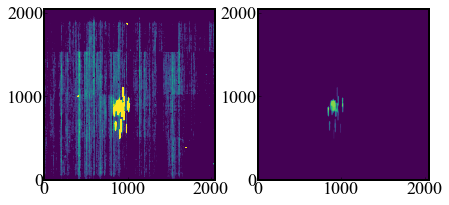

In [14]:
#from niriss_ghost.utils import get_ghost

orders = ['0','+1','+2','-1']
grating = 'GR150'
keyword_radius = 'semimajor_sigma' #'equivalent_radius'
#file_wfss_gap = path_ghost + 'gap_summary_wfss.txt'

infile = ratename

ids_seg = []
fig = plt.figure(figsize=(6.,4.))
fig.subplots_adjust(top=0.98, bottom=0.16, left=0.1, right=0.99, hspace=0.15, wspace=0.25)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Sci map;
fd = fits.open(infile)[1].data#[ymin:ymax,xmin:xmax]
vmin,vmax = np.percentile(fd,[50,95])
ax1.imshow(fd, origin='lower', vmin=vmin, vmax=vmax)

# Seg map;
# This was prepared by running photoutils on the dispersed image.
# See above.
fdseg0 = fits.open(infile.split('/')[-1].replace('.fits','_seg.fits'))[0].data#[ymin:ymax,xmin:xmax]

for order in orders:
    print('Working on order: %s'%order)

    # Open catalog;
    # These (_src) are actually for ghost
    x_src = fd_cat['x'] #- 1 # -1 for python - DS9 conversion...
    y_src = fd_cat['y'] #- 1 # -1 for python - DS9 conversion...
    id_src = fd_cat['id']
    is_this_ghost = fd_cat['is_this_ghost']

    # Plot 2D;
    box_size = 40 

    for jj in range(len(id_src)):
        if is_this_ghost[jj] == 'True':
            continue

        src_size = fd_src[keyword_radius][jj].value * 2
        pos = [x_src[jj],y_src[jj]]

        xss,yss,xcen,ycen = get_corners(pos[0], pos[1], filt, C, ORD=order, delx=40, dely=40)
        x0s,x1s,y0s,y1s = xss[0],xss[-1],yss[0],yss[-1]

        if grism == 'C':
            ymin, ymax = int(np.min(yss)-box_size/2.), int(np.max(yss)+box_size/2.)
            xmin, xmax = int(np.min(xss)), int(np.max(xss))
        else:
            xmin, xmax = int(np.min(xss)-box_size/2.), int(np.max(xss)+box_size/2.)
            ymin, ymax = int(np.min(yss)), int(np.max(yss))

        # Boundary check:
        if ymin < 0:
            ymin = 0
        fdseg = fdseg0[ymin:ymax,xmin:xmax]

        ymid = (ymax+ymin)/2.
        xmid = (xmax+xmin)/2.

        # Check seg map. 
        # Check along cross-disp direction, at the peal position along disp direction.
        # ii : element along cross disp direction.
        if grism == 'C':
            for ixx,xx in enumerate(xss-xmin):
                for ii in range(int(yss[ixx]-src_size/2.-ymin),int(yss[ixx]+src_size/2.-ymin),1):
                    try:
                        id_trace = fdseg[ii,int(xx)]
                        if id_trace>0 and not id_trace in ids_seg:
                            ids_seg.append(id_trace)
                    except:
                        pass
        else:
            #ax2.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            for iyy,yy in enumerate(yss-ymin):
                for ii in range(int(xss[iyy]-src_size/2.-xmin),int(xss[iyy]+src_size/2.-xmin),1):
                    try:
                        id_trace = fdseg[int(yy),ii]
                        if id_trace>0 and not id_trace in ids_seg:
                            ids_seg.append(id_trace)
                    except:
                        pass

fdseg_src = np.zeros(fdseg0.shape, 'float')
fdseg_gst = fdseg0

for id_seg in ids_seg:
    con = np.where(fdseg0 == id_seg)
    fdseg_src[con] = id_seg
    fdseg0[con] = 0

ax2.imshow(fdseg_src, origin='lower')

file_out_src = infile.split('/')[-1].replace('.fits','_src_seg.fits')
file_out_gst = infile.split('/')[-1].replace('.fits','_gst_seg.fits')

hdu = fits.PrimaryHDU(fdseg_src)
hdu.writeto(file_out_src, overwrite=True)
print('src id seg map is saved to %s'%file_out_src)

hdu_gst = fits.PrimaryHDU(fdseg0)
hdu_gst.writeto(file_out_gst, overwrite=True)
print('ghost id seg map is saved to %s'%file_out_gst)

#print('Segmentation ids that are on the trace path are',ids_seg)
plt.savefig('src_mask.png')



### Each of the two plots show a segmentation map that tells from which source (in source catalog) each segment is originated. The one in left, src id seg map, is only for real sources (ie not flagged as ghosts) and right one, ghost id seg map, is only for ghosts.
<br>
Note: Because detection of trace was done by photutils in the cell above, tweak the detection threshould if you prefer.
<br><br>

## 2. Check the result for individual sources, and tweak DQ array.

### Now you are ready to check if any particular trace is originated from ghost or not. The cell below will go through the ghost catalog and check the predicted position in WFSS to see if there is significant signal; if so, it flags the trace as ghost in DQ array (if f_dq_tweak is set to True).

### In the following big cell, the input wfss image will be copied to a new file, as this cell updates the DQ array.

In [15]:
# For now, check one source; 
idstart = 21 # ID of the source in direct image. Can select other source by looking at ghost id seg map.
idend = idstart+1


In [16]:
# Then apply the same method, with ids_seg from the cell above.
f_new_outfile = False #True
f_plot_src = True
verbose = False
f_dq_tweak = True # Tweak DQ array at the position of identified ghost trace.

# Plot 2D;
box_size = 40 
src_size = 10

infile = ratename
outfile = infile.split('/')[-1].replace('.fits','_gst.fits')
file_seg = infile.split('/')[-1].replace('.fits','_seg.fits')

# Make a copy;
if not os.path.exists(outfile):
    f_new_outfile = True
if f_new_outfile:
    os.system('cp %s %s'%(infile, outfile))

fd_data = fits.open(outfile)[1].data

# Loop over the source list;
for idtarg in range(idstart,idend,1):    
    try:
        iin = np.where(fd_cat['id'] == idtarg)[0][0]
        print('Current target: %d'%idtarg)
    except:
        print('ID%d not found. Skipping.'%idtarg)
        continue

    # Check if the source is a ghost;
    if fd_cat['is_this_ghost'][iin] == 'False': # careful, this element is string...
        print('This object is not ghost. Skipping.')
        continue
    
    # Fig;
    fig = plt.figure(figsize=(8.,2.2*len(orders)))
    fig.subplots_adjust(top=0.94, bottom=0.12, left=0.1, right=0.99, hspace=0.0, wspace=0.05)

    for oo,order in enumerate(orders):
        ax1 = fig.add_subplot(len(orders),3,3*oo+1)
        ax2 = fig.add_subplot(len(orders),3,3*oo+2)
        ax3 = fig.add_subplot(len(orders),3,3*oo+3)

        print('Working on order: %s'%order)
        ids_seg_gst = []

        # Open ghost-id catalog;
        x_gst = fd_cat['x'][iin] # -1 for python - DS9 conversion...
        y_gst = fd_cat['y'][iin] # -1 for python - DS9 conversion...
        id_gst = fd_cat['id'][iin]
        id_src = fd_cat['id_src'][iin]
        # Retrieve index for ghost
        iis = np.where(fd_cat['id'] == id_src)

        x_src = fd_cat['x'][iis] #- 1 # -1 for python - DS9 conversion...
        y_src = fd_cat['y'][iis] #- 1 # -1 for python - DS9 conversion...
        f_src = 1 #fd_cat['f_src_direct'][iin] 
        f_gst = 1 #fd_cat['f_gst_direct'][iin] 

        pos = [x_gst,y_gst]
        print('Target ghost positions in direct image are:',pos)

        xss,yss,xcen,ycen = get_corners(pos[0], pos[1], filt, C, ORD=order, delx=40, dely=40)
        x0s,x1s,y0s,y1s = xss[0],xss[-1],yss[0],yss[-1]

        if grism == 'C':
            ymin, ymax = int(np.min(yss)-box_size/2.), int(np.max(yss)+box_size/2.)
            xmin, xmax = int(np.min(xss)), int(np.max(xss))
        else:
            xmin, xmax = int(np.min(xss)-box_size/2.), int(np.max(xss)+box_size/2.)
            ymin, ymax = int(np.min(yss)), int(np.max(yss))

        ymid = (ymax+ymin)/2.
        xmid = (xmax+xmin)/2.
        print('Or, in wfss image:',[xmid,ymid])

        # This has to come after ymid, xmid
        if xmin<0:
            xmin = 0
        if ymin<0:
            ymin = 0
        if xmax>fd_data.shape[1]:
            xmax = fd_data.shape[1]
        if ymax>fd_data.shape[0]:
            ymax = fd_data.shape[0]
            
        # Open data;
        fd = fd_data[ymin:ymax,xmin:xmax]

        # Science extension;
        vmin,vmax = np.percentile(fd,[50,95])
        ax1.imshow(fd, origin='lower', vmin=vmin, vmax=vmax)
        ax1.plot(xss-xmin, yss-ymin, linestyle='--', lw=0.5, color='r')
        if grism == 'C':
            ax1.plot(xss-xmin, yss-src_size/2.-ymin, linestyle='--', lw=1, color='r')
            ax1.plot(xss-xmin, yss+src_size/2.-ymin, linestyle='--', lw=1, color='r')
        else:
            ax1.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            ax1.plot(xss+src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
        ax1.plot(xcen-xmin,ycen-ymin, 'x', ms=10)
        if oo == 0:
            ax1.set_title('science')
        ax1.set_ylabel('Order : %s'%order)

        # Seg extension;
        fdseg = fits.open(infile.split('/')[-1].replace('.fits','_seg.fits'))[0].data[ymin:ymax,xmin:xmax]
        ax2.imshow(fdseg, origin='lower')
        ax2.plot(xss-xmin, yss-ymin, linestyle='--', lw=0.5, color='r')
        if grism == 'C':
            ax2.plot(xss-xmin, yss-src_size/2.-ymin, linestyle='--', lw=1, color='r')
            ax2.plot(xss-xmin, yss+src_size/2.-ymin, linestyle='--', lw=1, color='r')
        else:
            ax2.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            ax2.plot(xss+src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
        ax2.plot(xcen-xmin, ycen-ymin, 'x', ms=10)
        if oo == 0:
            ax2.set_title('WFSS segmentation')


        # Check seg map. 
        # Check along cross-disp direction, at the peal position along disp direction.
        # ii : element along cross disp direction.
        if grism == 'C':
            for ixx,xx in enumerate(xss-xmin):
                for ii in range(int(yss[ixx]-src_size/2.-ymin),int(yss[ixx]+src_size/2.-ymin),1):
                    try:
                        id_trace = fdseg[ii,int(xx)]
                        if id_trace>0 and not id_trace in ids_seg_gst and not id_trace in ids_seg:
                            ids_seg_gst.append(id_trace)
                    except:
                        pass
        else:
            #ax2.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            for iyy,yy in enumerate(yss-ymin):
                for ii in range(int(xss[iyy]-src_size/2.-xmin),int(xss[iyy]+src_size/2.-xmin),1):
                    try:
                        id_trace = fdseg[int(yy),ii]
                        if id_trace>0 and not id_trace in ids_seg_gst and not id_trace in ids_seg:
                            ids_seg_gst.append(id_trace)
                    except:
                        pass

        if verbose:
            print('Segmentation ids that are on the trace path are',ids_seg_gst)

            
        # DQ tweaking;
        if f_dq_tweak:
            try:
                DQ_SET = 1
                with fits.open(outfile, mode='update') as hdul:
                    for nseg in ids_seg_gst:
                        con = np.where(fdseg == nseg)
                        hdul['DQ'].data[ymin:ymax,xmin:xmax][con] = DQ_SET

                    ax3.imshow(hdul['DQ'].data[ymin:ymax,xmin:xmax], vmin=0, vmax=1, origin='lower')
                    if oo == 0:
                        ax3.set_title('DQ')
                    hdul.flush()  # changes are written back to original fits
            except:
                pass

    print(id_gst,id_src,file_cat)
    ax1.text(0,-50,'Showing results for \nGhost ID : %d\n(originated from Source ID : %d)\nin %s'%(id_gst,id_src,file_cat),fontsize=10)
    #out_plot = 'ghost_wfss_mask_srcid%d.png'%idtarg #(id_src)
    out_plot = 'ghost_wfss_mask_id%d.png'%(idtarg)

    fig.savefig(out_plot, transparent=False)
    print('plot saved to: %s'%(out_plot))

    plt.close()


ID0 not found. Skipping.
Current target: 1
Working on order: 0
Target ghost positions in direct image are: [1361.989389, 625.0999017]
Or, in wfss image: [1362.0, 833.5]
Working on order: +1
Target ghost positions in direct image are: [1361.989389, 625.0999017]
Or, in wfss image: [1359.5, 418.5]
Working on order: +2
Target ghost positions in direct image are: [1361.989389, 625.0999017]
Or, in wfss image: [1357.5, 5.5]
Working on order: -1
Target ghost positions in direct image are: [1361.989389, 625.0999017]
Or, in wfss image: [1364.5, 1248.0]
1 25.0 ./output/ghost_detected_cat_jw01090001001_01101_00049_nis_cal.txt
plot saved to: ghost_wfss_mask_id1.png
Current target: 2
Working on order: 0
Target ghost positions in direct image are: [1296.1049384, 750.9245935]
Or, in wfss image: [1296.0, 959.5]
Working on order: +1
Target ghost positions in direct image are: [1296.1049384, 750.9245935]
Or, in wfss image: [1293.5, 544.5]
Working on order: +2
Target ghost positions in direct image are: [